# Prepare stock market data

## Task 1. a

### 1. Find all stock csv files (incorrectly labelled as txt)

In [1]:
import glob

base_path = './stock-market/Data/Stocks'
paths = []

for file in glob.glob(base_path + '/*.txt'):
    paths.append(file)

paths[:5]

['./stock-market/Data/Stocks/iba.us.txt',
 './stock-market/Data/Stocks/wpz.us.txt',
 './stock-market/Data/Stocks/opnt.us.txt',
 './stock-market/Data/Stocks/indf.us.txt',
 './stock-market/Data/Stocks/flic.us.txt']

### 2. Create dataframe while removing empty files

In [6]:
import pandas as pd

df_list = []
empty_file_symbols = []

count = 0
for path in paths:
    count += 1
    symbol = path.split('/')[-1].split('.')[0]

    # Attempt to read the stock data
    try:
        stock_df = pd.read_csv(path)
        stock_df['Symbol'] = symbol
        df_list.append(stock_df)

    # If stock data is invalid or doens't exist, ignore
    except:
        empty_file_symbols.append(symbol)

df = pd.concat(df_list, ignore_index=True)
df['Date'] = pd.to_datetime(df['Date'])
df['Symbol'] = df['Symbol'].astype('string')

df.head()

,Date,Open,High,Low,Close,Volume,OpenInt,Symbol
0,2005-02-25,12.868,12.982,12.834,12.834,15928,0,iba
1,2005-02-28,13.536,13.536,13.273,13.281,16382,0,iba
2,2005-03-01,13.185,13.299,13.185,13.299,1250,0,iba
3,2005-03-02,13.361,13.395,13.273,13.291,8760,0,iba
4,2005-03-03,13.361,13.404,12.966,13.218,9897,0,iba


In [29]:

work = df.copy()
date_col = "Date"
symbol_col = "Symbol"

# Keep original column order; detect data columns to forward-fill
cols = list(work.columns)
value_cols = [c for c in cols if c not in (date_col, symbol_col)]

filled_groups = []
for sym, g in work.groupby(symbol_col, sort=False):
    g = g.sort_values(date_col).set_index(date_col)

    # Business-day range (Mon–Fri)
    idx = pd.date_range(start=g.index.min(), end=g.index.max(), freq="B")

    # Reindex and forward-fill from previous trading day
    gi = g.reindex(idx)
    gi[symbol_col] = sym
    gi[value_cols] = gi[value_cols].ffill()  # prior trading day values

        # Done for this symbol
    gi.index.name = date_col
    filled_groups.append(gi.reset_index())

df_filled = (
    pd.concat(filled_groups, ignore_index=True)
        .sort_values([symbol_col, date_col], kind="mergesort")
    )


# Optional: enforce dtypes from original df where possible
for c in value_cols:
    try:
        df_filled[c] = df_filled[c].astype(df[c].dtype)
    except Exception:
        pass

df_filled.head()

,Date,Open,High,Low,Close,Volume,OpenInt,Symbol
9829374,1999-11-18,30.713,33.754,27.002,29.702,66277506,0,a
9829375,1999-11-19,28.986,29.027,26.872,27.257,16142920,0,a
9829376,1999-11-22,27.886,29.702,27.044,29.702,6970266,0,a
9829377,1999-11-23,28.688,29.446,27.002,27.002,6332082,0,a
9829378,1999-11-24,27.083,28.309,27.002,27.717,5132147,0,a


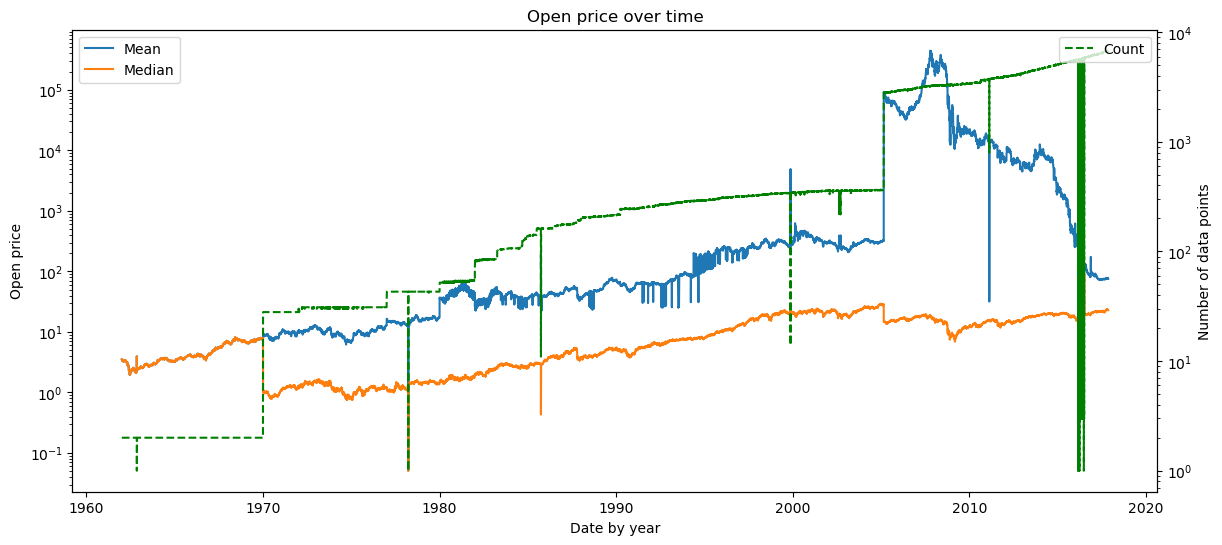

In [30]:
import matplotlib.pyplot as plt

date_data = df.groupby('Date')
dates = date_data.indices.keys()

fig, ax1 = plt.subplots(figsize=(14,6))  # wider plots

# Left axis: mean & median
ax1.plot(dates, date_data['Open'].mean(), label='Mean')
ax1.plot(dates, date_data['Open'].median(), label='Median')
ax1.set_xlabel('Date by year')
ax1.set_ylabel('Open price')
ax1.set_yscale('log') 
ax1.legend(loc='upper left')

# Right axis: count of data points
ax2 = ax1.twinx()
ax2.plot(dates, date_data['Open'].count(), label='Count', color='green', linestyle='--')
ax2.set_ylabel('Number of data points')
ax2.legend(loc='upper right')
ax2.set_yscale("log")

plt.title('Open price over time')
plt.show()

In [33]:
pd.set_option('display.float_format', '{:.2f}'.format)
df.describe()

,Open,High,Low,Close,Volume,OpenInt
count,14887665.00,14887665.00,14887665.00,14887665.00,14887665.00,14887665.00
mean,30385.38,31212.47,29361.76,30245.22,1585730.32,0.00
std,4202500.95,4323485.55,4046981.00,4180590.07,7635186.71,0.00
min,0.00,0.00,-1.00,0.00,0.00,0.00
25%,7.75,7.88,7.61,7.75,32800.00,0.00
50%,15.68,15.92,15.43,15.68,192266.00,0.00
75%,28.90,29.28,28.50,28.90,891786.00,0.00
max,1423712891.00,1442048636.45,1362117843.98,1437986240.44,2423735131.00,0.00


### 3. Show column data types

In [4]:
print('Data types of columns:')
print(df.dtypes)

Data types of columns:
Date       datetime64[ns]
Open              float64
High              float64
Low               float64
Close             float64
Volume              int64
OpenInt             int64
Symbol     string[python]
dtype: object


### 4. Summary statistics

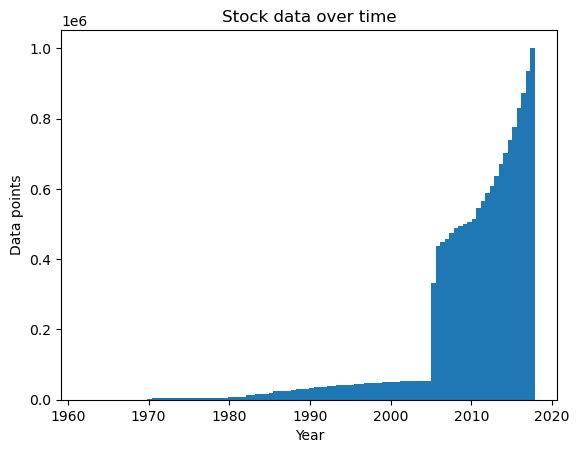

In [55]:
import matplotlib.pyplot as plt

plt.hist(data=df, x='Date', bins=100)
plt.title('Stock data over time')
plt.xlabel('Year')
plt.ylabel('Data points')
plt.show()

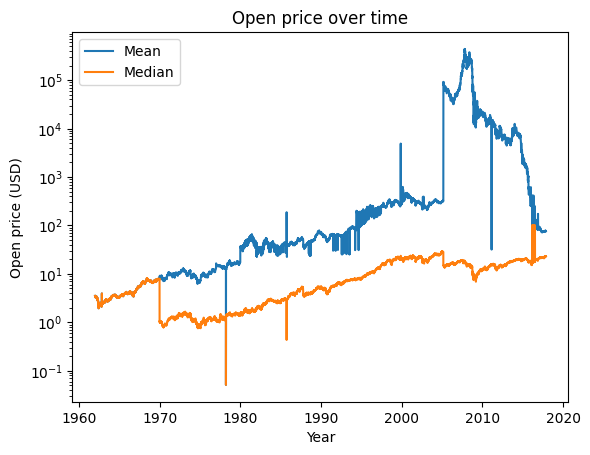

In [6]:
date_data = df.groupby('Date')
dates = date_data.indices.keys()

plt.plot(dates, date_data['Open'].mean(), label='Mean')
plt.plot(dates, date_data['Open'].median(), label='Median')
plt.title('Open price over time')
plt.xlabel('Year')
plt.ylabel('Open price (USD)')
plt.yscale('log')
plt.legend()
plt.show()

## Task 1. b

### 1. Find missing values

In [7]:
print('Missing values in data:')
print(df.isna().sum())

print('\nStock symbols with empty files:')
print(len(empty_file_symbols), '-', empty_file_symbols)

Missing values in data:
Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
OpenInt    0
Symbol     0
dtype: int64

Stock symbols with empty files:
32 - ['vist', 'bolt', 'ehr', 'rbio', 'pbio', 'sfix', 'boxl', 'asns', 'accp', 'bxg', 'amrhw', 'sail', 'amrh', 'stnl', 'scci', 'vmet', 'pxus', 'hayu', 'send', 'mapi', 'srva', 'bbrx', 'znwaa', 'sbt', 'wnfm', 'fmax', 'molc', 'wspt', 'gnst', 'scph', 'jt', 'otg']


## Task 2. a

### Ignore empty/invalid csv's

In [9]:
print('Total stock csv\'s:', len(paths))
print('Empty/invalid stock csv\'s:', len(empty_file_symbols))

Total stock csv's: 7195
Empty/invalid stock csv's: 32


Ignore empty or invalid stock csv's since there are way less than the total.

In [ ]:
work = df.copy()
date_col = "Date"
symbol_col = "Symbol"

# Keep original column order; detect data columns to forward-fill
cols = list(work.columns)
value_cols = [c for c in cols if c not in (date_col, symbol_col)]

filled_groups = []
for sym, g in work.groupby(symbol_col, sort=False):
    g = g.sort_values(date_col).set_index(date_col)

    # Business-day range (Mon–Fri)
    idx = pd.date_range(start=g.index.min(), end=g.index.max(), freq="B")

    # Reindex and forward-fill from previous trading day
    gi = g.reindex(idx)
    gi[symbol_col] = sym
    gi[value_cols] = gi[value_cols].ffill()  # prior trading day values

        # Done for this symbol
    gi.index.name = date_col
    filled_groups.append(gi.reset_index())

df_filled = (
    pd.concat(filled_groups, ignore_index=True)
        .sort_values([symbol_col, date_col], kind="mergesort")
    )


# Optional: enforce dtypes from original df where possible
for c in value_cols:
    try:
        df_filled[c] = df_filled[c].astype(df[c].dtype)
    except Exception:
        pass

df_filled.head() 

,Date,Open,High,Low,Close,Volume,OpenInt,Symbol
0,1999-11-18,30.71,33.75,27.00,29.70,66277506,0,a
1,1999-11-19,28.99,29.03,26.87,27.26,16142920,0,a
2,1999-11-22,27.89,29.70,27.04,29.70,6970266,0,a
3,1999-11-23,28.69,29.45,27.00,27.00,6332082,0,a
4,1999-11-24,27.08,28.31,27.00,27.72,5132147,0,a


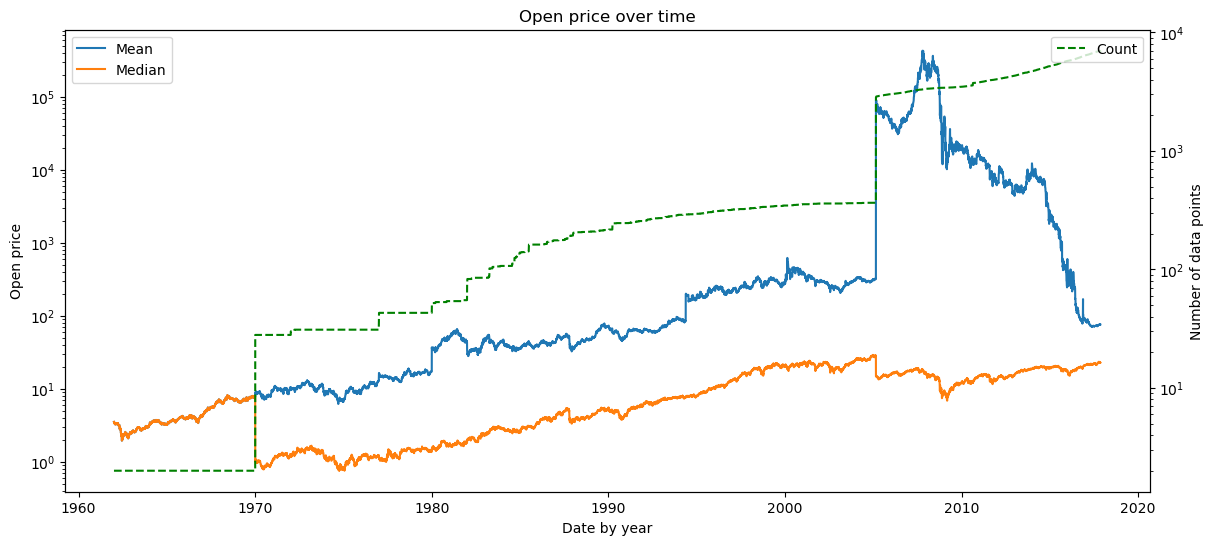

In [37]:
date_data = df_filled.groupby('Date')
dates = date_data.indices.keys()

fig, ax1 = plt.subplots(figsize=(14,6))  # wider plots

# Left axis: mean & median
ax1.plot(dates, date_data['Open'].mean(), label='Mean')
ax1.plot(dates, date_data['Open'].median(), label='Median')
ax1.set_xlabel('Date by year')
ax1.set_ylabel('Open price')
ax1.set_yscale('log') 
ax1.legend(loc='upper left')

# Right axis: count of data points
ax2 = ax1.twinx()
ax2.plot(dates, date_data['Open'].count(), label='Count', color='green', linestyle='--')
ax2.set_ylabel('Number of data points')
ax2.legend(loc='upper right')
ax2.set_yscale("log")

plt.title('Open price over time')
plt.show()

In [39]:
df = df_filled # use filled df

## Task 2. b

### Drop OpenInt since ever value is 0

In [40]:
print('Unique values in OpenInt column:', df['OpenInt'].unique())

df = df.drop(columns=['OpenInt'])

df.head()

Unique values in OpenInt column: [0]


,Date,Open,High,Low,Close,Volume,Symbol
0,1999-11-18,30.71,33.75,27.00,29.70,66277506,a
1,1999-11-19,28.99,29.03,26.87,27.26,16142920,a
2,1999-11-22,27.89,29.70,27.04,29.70,6970266,a
3,1999-11-23,28.69,29.45,27.00,27.00,6332082,a
4,1999-11-24,27.08,28.31,27.00,27.72,5132147,a


## Task 3. a

### Find z-score for each column

In [41]:
df = df[(df['Open'] >= 0)
   & (df['High'] >= 0)
   & (df['Low'] >= 0)
   & (df['Close'] >= 0) 
   & (df['Volume'] >= 0)]

In [42]:
import numpy as np

num_fields = ['Open', 'High', 'Low', 'Close', 'Volume']

df_scaled = df.copy()

df_scaled[num_fields] = df_scaled[num_fields].apply(np.log1p)

pd.set_option('display.float_format', '{:.4f}'.format)
df_scaled.head()

,Date,Open,High,Low,Close,Volume,Symbol
0,1999-11-18,3.4567,3.5483,3.3323,3.4243,18.0094,a
1,1999-11-19,3.4007,3.4021,3.3276,3.3413,16.5970,a
2,1999-11-22,3.3634,3.4243,3.3338,3.4243,15.7572,a
3,1999-11-23,3.3907,3.4160,3.3323,3.3323,15.6611,a
4,1999-11-24,3.3352,3.3779,3.3323,3.3575,15.4510,a


In [43]:
for field in num_fields:
    df_scaled[f'{field}_zscore'] = (df_scaled[field] - df_scaled[field].mean())/df_scaled[field].std(ddof=0)

df_scaled.head()

,Date,Open,High,Low,Close,Volume,Symbol,Open_zscore,High_zscore,Low_zscore,Close_zscore,Volume_zscore
0,1999-11-18,3.4567,3.5483,3.3323,3.4243,18.0094,a,0.6057,0.6783,0.5035,0.5757,2.3324
1,1999-11-19,3.4007,3.4021,3.3276,3.3413,16.5970,a,0.5538,0.5427,0.4992,0.4988,1.8028
2,1999-11-22,3.3634,3.4243,3.3338,3.4243,15.7572,a,0.5192,0.5633,0.5049,0.5757,1.4878
3,1999-11-23,3.3907,3.4160,3.3323,3.3323,15.6611,a,0.5446,0.5555,0.5035,0.4904,1.4518
4,1999-11-24,3.3352,3.3779,3.3323,3.3575,15.4510,a,0.4930,0.5202,0.5035,0.5138,1.3730


In [44]:
df_scaled[(df_scaled['Open_zscore'] > 3) | (df_scaled['Open_zscore'] < -3)
   | (df_scaled['High_zscore'] > 3) | (df_scaled['High_zscore'] < -3)
   | (df_scaled['Low_zscore'] > 3) | (df_scaled['Low_zscore'] < -3)
   | (df_scaled['Close_zscore'] > 3) | (df_scaled['Close_zscore'] < -3)
   | (df_scaled['Volume_zscore'] > 3) | (df_scaled['Volume_zscore'] < -3)]

,Date,Open,High,Low,Close,Volume,Symbol,Open_zscore,High_zscore,Low_zscore,Close_zscore,Volume_zscore
2722,2010-04-26,3.2441,3.2569,3.2433,3.2525,0.0000,a,0.4086,0.4079,0.4211,0.4164,-4.4214
15208,2010-04-26,3.4190,3.4287,3.4105,3.4125,0.0000,aa,0.5708,0.5674,0.5759,0.5647,-4.4214
17701,1996-04-12,0.7178,1.0260,0.7031,0.8671,19.8285,aaba,-1.9335,-1.6619,-1.9324,-1.7953,3.0146
20781,2008-02-01,3.3911,3.4285,3.3443,3.3803,19.8971,aaba,0.5449,0.5671,0.5146,0.5349,3.0404
21362,2010-04-26,2.9291,2.9291,2.9091,2.9118,0.0000,aaba,0.1165,0.1038,0.1114,0.1005,-4.4214
...,...,...,...,...,...,...,...,...,...,...,...,...
15771347,2016-01-28,0.5306,0.5306,0.5306,0.5306,0.0000,zionz,-2.1071,-2.1215,-2.0922,-2.1073,-4.4214
15792607,2005-05-05,2.3026,2.3026,2.3026,2.3026,0.0000,zumz,-0.4643,-0.4775,-0.4505,-0.4643,-4.4214
15795875,2017-11-01,4.6165,4.6165,4.6165,4.6165,0.0000,zvv,1.6810,1.6694,1.6933,1.6811,-4.4214
15795876,2017-11-02,4.6165,4.6165,4.6165,4.6165,0.0000,zvv,1.6810,1.6694,1.6933,1.6811,-4.4214


### Remove outliers (z-score below -3 or above 3)

In [45]:
df_scaled = df_scaled[(df_scaled['Open_zscore'] < 3) & (df_scaled['Open_zscore'] > -3)
   & (df_scaled['High_zscore'] < 3) & (df_scaled['High_zscore'] > -3)
   & (df_scaled['Low_zscore'] < 3) & (df_scaled['Low_zscore'] > -3)
   & (df_scaled['Close_zscore'] < 3) & (df_scaled['Close_zscore'] > -3)
   & (df_scaled['Volume_zscore'] < 3) & (df_scaled['Volume_zscore'] > -3)]

df_scaled.drop(columns=[f'{field}_zscore' for field in num_fields])

,Date,Open,High,Low,Close,Volume,Symbol
0,1999-11-18,3.4567,3.5483,3.3323,3.4243,18.0094,a
1,1999-11-19,3.4007,3.4021,3.3276,3.3413,16.5970,a
2,1999-11-22,3.3634,3.4243,3.3338,3.4243,15.7572,a
3,1999-11-23,3.3907,3.4160,3.3323,3.3323,15.6611,a
4,1999-11-24,3.3352,3.3779,3.3323,3.3575,15.4510,a
...,...,...,...,...,...,...,...
15798304,2017-11-06,2.4354,2.5289,2.4354,2.5006,13.7932,zyne
15798305,2017-11-07,2.5096,2.5193,2.4570,2.4706,13.0197,zyne
15798306,2017-11-08,2.4596,2.4899,2.4292,2.4765,12.7262,zyne
15798307,2017-11-09,2.4849,2.5538,2.4824,2.5337,13.0456,zyne


In [46]:
df_scaled.describe()

,Open,High,Low,Close,Volume,Open_zscore,High_zscore,Low_zscore,Close_zscore,Volume_zscore
count,15616908.0000,15616908.0000,15616908.0000,15616908.0000,15616908.0000,15616908.0000,15616908.0000,15616908.0000,15616908.0000,15616908.0000
mean,2.7606,2.7743,2.7461,2.7606,11.8631,-0.0397,-0.0398,-0.0396,-0.0397,0.0275
std,0.9593,0.9580,0.9606,0.9593,2.5517,0.8894,0.8888,0.8900,0.8894,0.9569
min,0.0000,0.0040,0.0000,0.0037,3.8067,-2.5990,-2.6101,-2.5838,-2.5959,-2.9939
25%,2.1529,2.1688,2.1377,2.1529,10.2932,-0.6030,-0.6016,-0.6032,-0.6031,-0.5613
50%,2.7970,2.8107,2.7820,2.7970,12.1153,-0.0059,-0.0061,-0.0063,-0.0060,0.1220
75%,3.3717,3.3844,3.3587,3.3718,13.6685,0.5270,0.5262,0.5280,0.5271,0.7045
max,6.0391,6.0506,6.0269,6.0389,19.7895,2.9999,3.0000,3.0000,2.9999,3.0000


In [50]:
df_test = df_scaled.copy()
df_test[num_fields] = df_test[num_fields].apply(np.expm1)

df_test.describe()

,Open,High,Low,Close,Volume,Open_zscore,High_zscore,Low_zscore,Close_zscore,Volume_zscore
count,15616908.0000,15616908.0000,15616908.0000,15616908.0000,15616908.0000,15616908.0000,15616908.0000,15616908.0000,15616908.0000,15616908.0000
mean,23.9484,24.2774,23.6052,23.9471,1538524.3919,-0.0397,-0.0398,-0.0396,-0.0397,0.0275
std,31.0181,31.4722,30.5339,31.0011,6816540.0933,0.8894,0.8888,0.8900,0.8894,0.9569
min,0.0000,0.0040,0.0000,0.0037,44.0000,-2.5990,-2.6101,-2.5838,-2.5959,-2.9939
25%,7.6100,7.7480,7.4800,7.6100,29530.0000,-0.6030,-0.6016,-0.6032,-0.6031,-0.5613
50%,15.3950,15.6210,15.1510,15.3950,182636.0000,-0.0059,-0.0061,-0.0063,-0.0060,0.1220
75%,28.1290,28.5000,27.7520,28.1320,863270.0000,0.5270,0.5262,0.5280,0.5271,0.7045
max,418.5300,423.3600,413.4200,418.4400,393062029.0000,2.9999,3.0000,3.0000,2.9999,3.0000


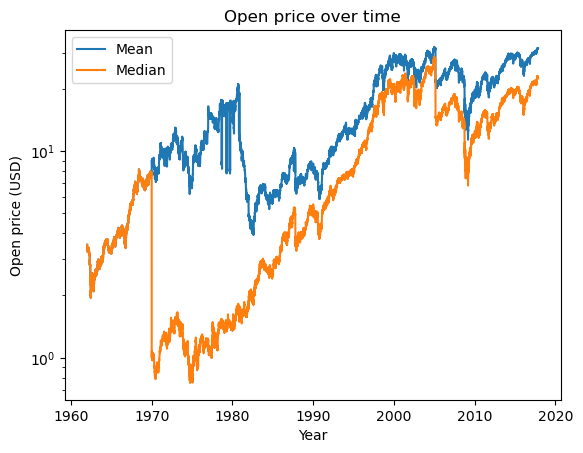

In [51]:
date_data = df_test.groupby('Date')
dates = date_data.indices.keys()

plt.plot(dates, date_data['Open'].mean(), label='Mean')
plt.plot(dates, date_data['Open'].median(), label='Median')
plt.title('Open price over time')
plt.xlabel('Year')
plt.ylabel('Open price (USD)')
plt.yscale('log')
plt.legend()
plt.show()

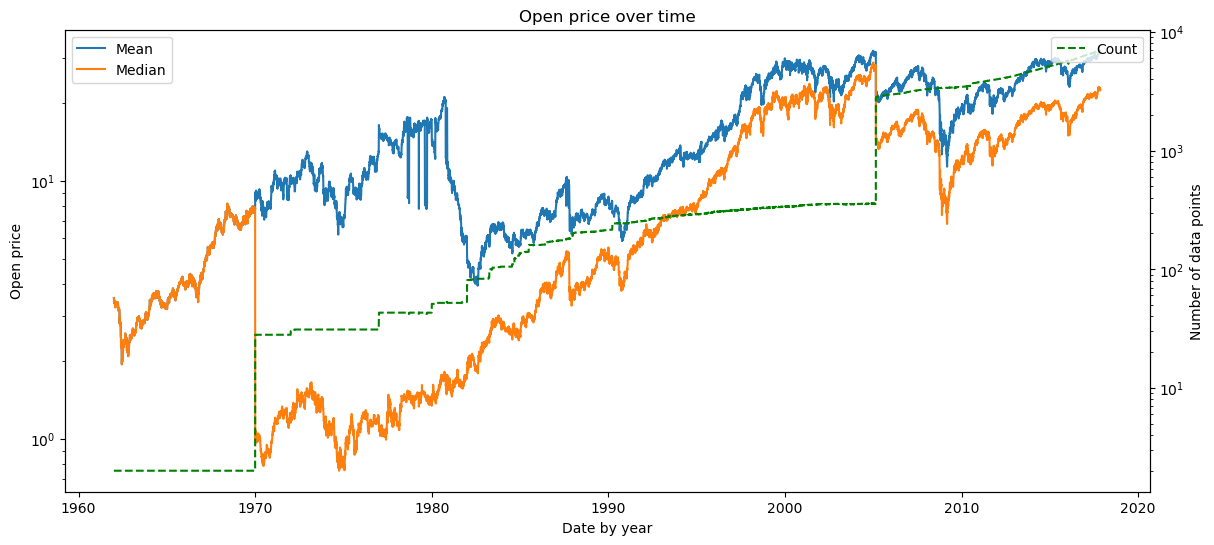

In [52]:
fig, ax1 = plt.subplots(figsize=(14,6))  # wider plots

# Left axis: mean & median
ax1.plot(dates, date_data['Open'].mean(), label='Mean')
ax1.plot(dates, date_data['Open'].median(), label='Median')
ax1.set_xlabel('Date by year')
ax1.set_ylabel('Open price')
ax1.set_yscale('log') 
ax1.legend(loc='upper left')

# Right axis: count of data points
ax2 = ax1.twinx()
ax2.plot(dates, date_data['Open'].count(), label='Count', color='green', linestyle='--')
ax2.set_ylabel('Number of data points')
ax2.legend(loc='upper right')
ax2.set_yscale("log")

plt.title('Open price over time')
plt.show()

In [21]:
df_scaled[num_fields] = df_scaled[num_fields].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
df.head()

,Date,Open,High,Low,Close,Volume,Symbol
0,2005-08-25,5.5182,5.5182,5.5182,5.5182,16962,sdrl
1,2005-09-01,6.1761,6.1761,6.1761,6.1761,1698,sdrl
2,2005-09-02,6.0700,6.1761,6.0347,6.0700,18727,sdrl
3,2005-09-06,5.9286,6.0700,5.7517,5.9286,55410,sdrl
4,2005-09-07,5.8224,6.1054,5.7517,5.8224,47212,sdrl


### Apply label encoding to Symbol column

In [22]:
from sklearn import preprocessing

df_scaled['Symbol_label'] = preprocessing.LabelEncoder().fit_transform(df_scaled['Symbol'])

df_scaled.head()

,Date,Open,High,Low,Close,Volume,Symbol,Open_zscore,High_zscore,Low_zscore,Close_zscore,Volume_zscore,Symbol_label
0,2005-08-25,0.3108,0.3097,0.3114,0.3104,0.3572,sdrl,-0.8712,-0.8849,-0.8568,-0.8712,-0.8540,5756
1,2005-09-01,0.3267,0.3257,0.3274,0.3263,0.2071,sdrl,-0.7817,-0.7953,-0.7674,-0.7817,-1.7538,5756
2,2005-09-02,0.3242,0.3257,0.3241,0.3238,0.3636,sdrl,-0.7956,-0.7953,-0.7859,-0.7955,-0.8153,5756
3,2005-09-06,0.3209,0.3232,0.3172,0.3205,0.4344,sdrl,-0.8144,-0.8092,-0.8241,-0.8143,-0.3911,5756
4,2005-09-07,0.3183,0.3240,0.3172,0.3179,0.4239,sdrl,-0.8288,-0.8046,-0.8241,-0.8287,-0.4537,5756
